# Chabot with Dialogflow

<img src="./assets/images/logo.png" width="300" />

[Dialogflow](https://dialogflow.cloud.google.com) ist eine Platform mit der Chabots erstellt und bearbeitet werden können.   
<br><br>
Es bietete dabei eine Webobefläche mit der Inhalte des Chatbots anpassen lassen.  
Außerdem gibt es eine [Client Libary](https://github.com/googleapis/python-dialogflow) für Python, die im Rahmen dieses Projektes die Kommunikation mit Dialogflow ermöglicht.

In [1]:
from google.cloud import dialogflow_v2 as df
import os
import json
import uuid
import requests
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas

Als erstes werden ein paar Konstanten angelegt, welche im Projekt immer wieder benötigt werden.

In [2]:
key_file_path='./keys/private_key.json'
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = key_file_path
key_file = json.load(open(key_file_path))

project_id = key_file["project_id"]
session_id = uuid.uuid4()
language_code = 'de'

Entwickeln einer Funktion mit der man die Absicht einer Texteingabe ermitteln kann.

In [3]:
session_client = df.SessionsClient()

def detected_intent(text: str) -> df.DetectIntentResponse:
    session = session_client.session_path(project_id, session_id)
    text_input = df.TextInput(text=text, language_code=language_code)
    query_input = df.QueryInput(text=text_input)

    response = session_client.detect_intent(
        request = {
            'session': session,
            'query_input': query_input
        }
    )

    return response

In [110]:
detected_intent("Hallo")

response_id: "a7ec24bd-5eba-4b3e-84c7-eb8787586e28-bd76d68e"
query_result {
  query_text: "Hallo"
  language_code: "de"
  action: "input.welcome"
  parameters {
  }
  all_required_params_present: true
  fulfillment_text: "Ich grüße dich!"
  fulfillment_messages {
    text {
      text: "Ich grüße dich!"
    }
  }
  intent {
    name: "projects/school-project-hwq9/agent/intents/b4660823-7f21-40de-af85-3cc9a3394ced"
    display_name: "Default Welcome Intent"
  }
  intent_detection_confidence: 1
}

In [59]:
while True:
    text = input("You: ")
    if (text == 'q'):
        break
    
    result = detected_intent(text)
    print(f'Bot: {result.query_result.fulfillment_text}')
    

In [4]:
class ChatbotCryptoResult:
    result: np.array = None

class ChatbotResultMessage:
    text_result: str = None
    crypto_result: ChatbotCryptoResult = None

In [5]:
def parse_intent_response(intent_response: df.DetectIntentResponse) -> ChatbotResultMessage:
    query_result : df.QueryResult = intent_response.query_result

    text = query_result.fulfillment_text
    ret = ChatbotResultMessage()
    ret.text_result = text

    intent_name = query_result.intent.display_name

    if intent_name == 'crypto_price':
        coin_id = query_result.parameters['crypto']
        ret.crypto_result = get_crypto_chart(coin_id)

    return ret


def get_crypto_chart(coin_id: str):
    # https://www.coingecko.com/en/api/documentation
    resposne = requests.get(f"https://api.coingecko.com/api/v3/coins/{coin_id}/market_chart?vs_currency=eur&days=300&interval=daily")
    token_history = resposne.json()['prices']
    return np.array(token_history)



0      32740.319364
1      32442.868786
2      36399.056660
3      36241.709220
4      37089.686816
           ...     
296    15868.296187
297    15801.201051
298    15872.199812
299    15683.633333
300    15897.602504
Name: price, Length: 301, dtype: float64


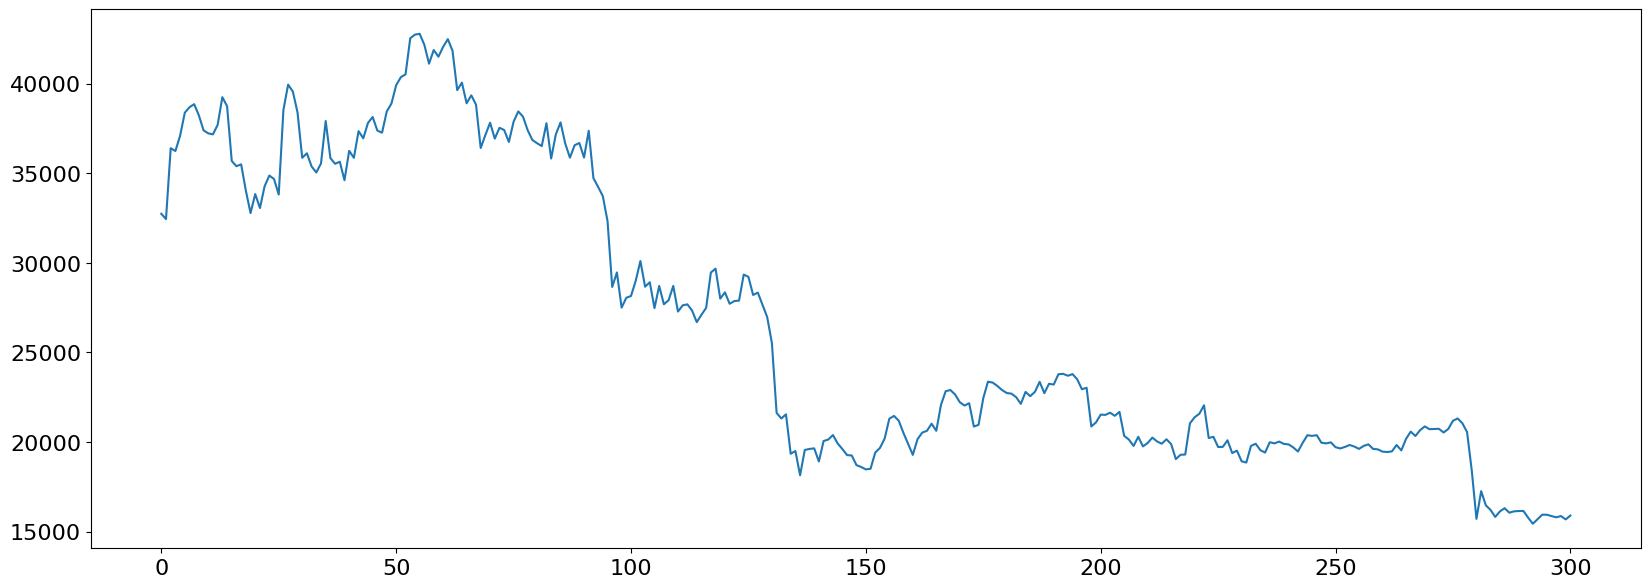

In [21]:
detect_intent_result = detected_intent("Bitcoin preis")
result = parse_intent_response(detect_intent_result)

if result.text_result is not None:
    print(result.text_result)

if result.crypto_result is not None:
    # time = [res[0] for res in result.crypto_result]
    # price = [res[1] for res in result.crypto_result]    
    # sns.set(rc={'figure.figsize':(13,9)})
    # line = sns.lineplot(
    #  x = 'time',
    #  y = 'price',
    #  data = [time, price]   
    # )

    data_frame = pandas.DataFrame(result.crypto_result, columns = ["time", "price"])
    print(data_frame.loc[:, 'price'])
    price = data_frame.loc[:, 'price'].copy()
    price.plot(figsize=(20, 7), fontsize=16)
    # plt.style.use('seaborn')
    # plt.show()
    # print(data_frame)
    # print(time)